# Analyze

## なにをするのか

Business goalを達成するために現状手に入るデータが必要十分であるか、データ分析を行いAnalysis Reportを作成します。

## なぜやるのか

機械学習モデルの開発には必要十分なデータが必要です。しかし、機械学習の知見がないステークホルダーが必要性と十分性を判断するのは困難です。データサイエンティストが定量的に欠けているデータと不足しているデータを示さなければ、ステークホルダーは日常業務の合間でどれだけ工数を割いて準備すればよいのか見積もることができません。Analyzeにより現状のデータの不足と不十分性を定量的に示したAnalysis Reportを作成し、次のPrepareフェーズで必要なステークホルダーに対し依頼を行います。

## どうやるのか

プログラミング演習で定量的な分析を行い、コミュニケーション演習で必要性と十分性を確認するための質問を作成します。

### プログラミング演習

データの必要性と十分性を分析します。

#### 十分性の分析

データを読み込み、量を把握します。  
今回は`house_prices.csv`というデータを渡されているとし、それを`house_price_df`という変数に読み込みます。データの読み込みには`pandas`というライブラリを使用します。

In [1]:
from pathlib import Path
import pandas as pd


raw_data_path = Path("../data/raw/house_prices.csv")
house_price_df = pd.read_csv(raw_data_path, na_values="?")

`info`関数でデータの列名、形式、空白(null)でない値の件数がわかります。

*Exercise: `info`を`describe`に変更してみましょう。データ各列の平均や分散(基本統計量)を参照できます。*

In [2]:
house_price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

データ件数をプロットすることで空白が多い項目を視覚的に把握することができます。次のコードで、空白データの割合を棒グラフで表示します。

*Exercise: `barh`を`bar`に変更してみましょう。利用可能なチャートは[Chart Visualization](https://pandas.pydata.org/docs/user_guide/visualization.html#area-plot)で確認できます。*

<AxesSubplot:ylabel='index'>

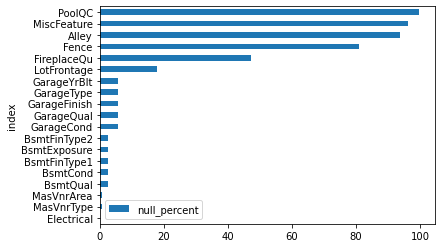

In [3]:
house_price_df\
   .isnull().sum().divide(len(house_price_df)).multiply(100)\
   .reset_index(name="null_percent").query("null_percent > 0.0")\
   .sort_values("null_percent")\
   .set_index("index").plot.barh()

**`PoolQC`など上位5つほどは半分以上空白の値があることがわかります。**

#### 必要性の分析

データの必要性を把握するために、予測したい販売価格(`SalePrice`)との相関を計算します。相関が高い項目がなければ、予測にとって重要なデータが欠けていることを示唆しています。データ項目同士の相関係数は、`corr`関数で計算できます。ただ、相関係数が計算できるのは項目が数値同士の場合のみです。`SalePrice`に対し`SalePrice`自身も含め相関係数を取りプロットします。

<AxesSubplot:>

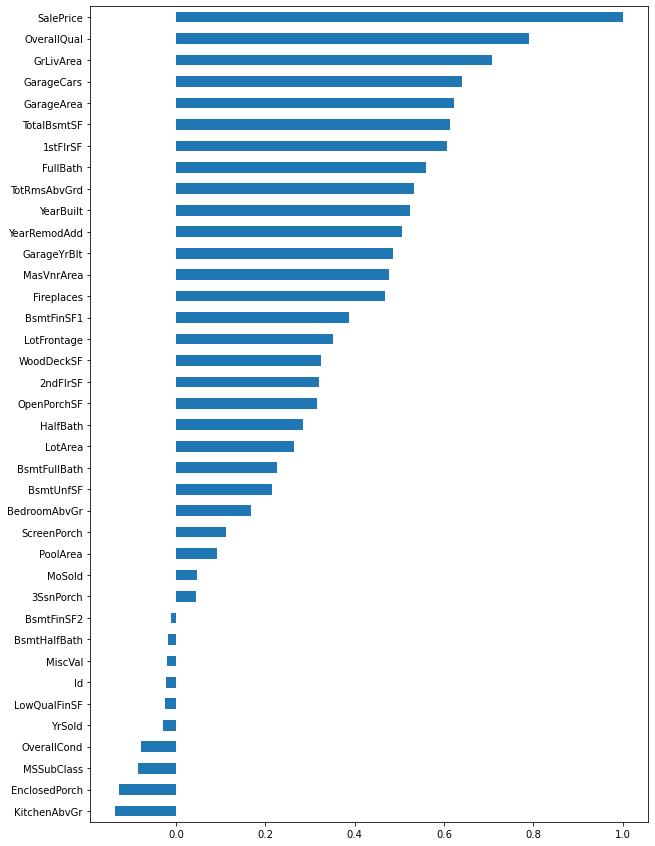

In [4]:
numerical_df = house_price_df.select_dtypes("number")
numerical_df.corr()["SalePrice"].sort_values().plot.barh(figsize=(10,15))

**`OverallQual`などの項目が価格の予測に強く影響していることがわかります。**

ドロップダウンリストから選ぶようなカテゴリ項目(間取りがA、B、Cの3つどれかなど)は相関係数が計算できません。そのため、[ボックスプロット](https://ja.wikipedia.org/wiki/%E7%AE%B1%E3%81%B2%E3%81%92%E5%9B%B3#:~:text=%E7%AE%B1%E3%81%B2%E3%81%92%E5%9B%B3%EF%BC%88%E3%81%AF%E3%81%93,1970%E5%B9%B4%E4%BB%A3%E3%81%AB%E6%8F%90%E5%94%B1%E3%81%97%E3%81%9F%E3%80%82)でカテゴリごとに`SalePrice`の分布が変わっていないかを可視化します。

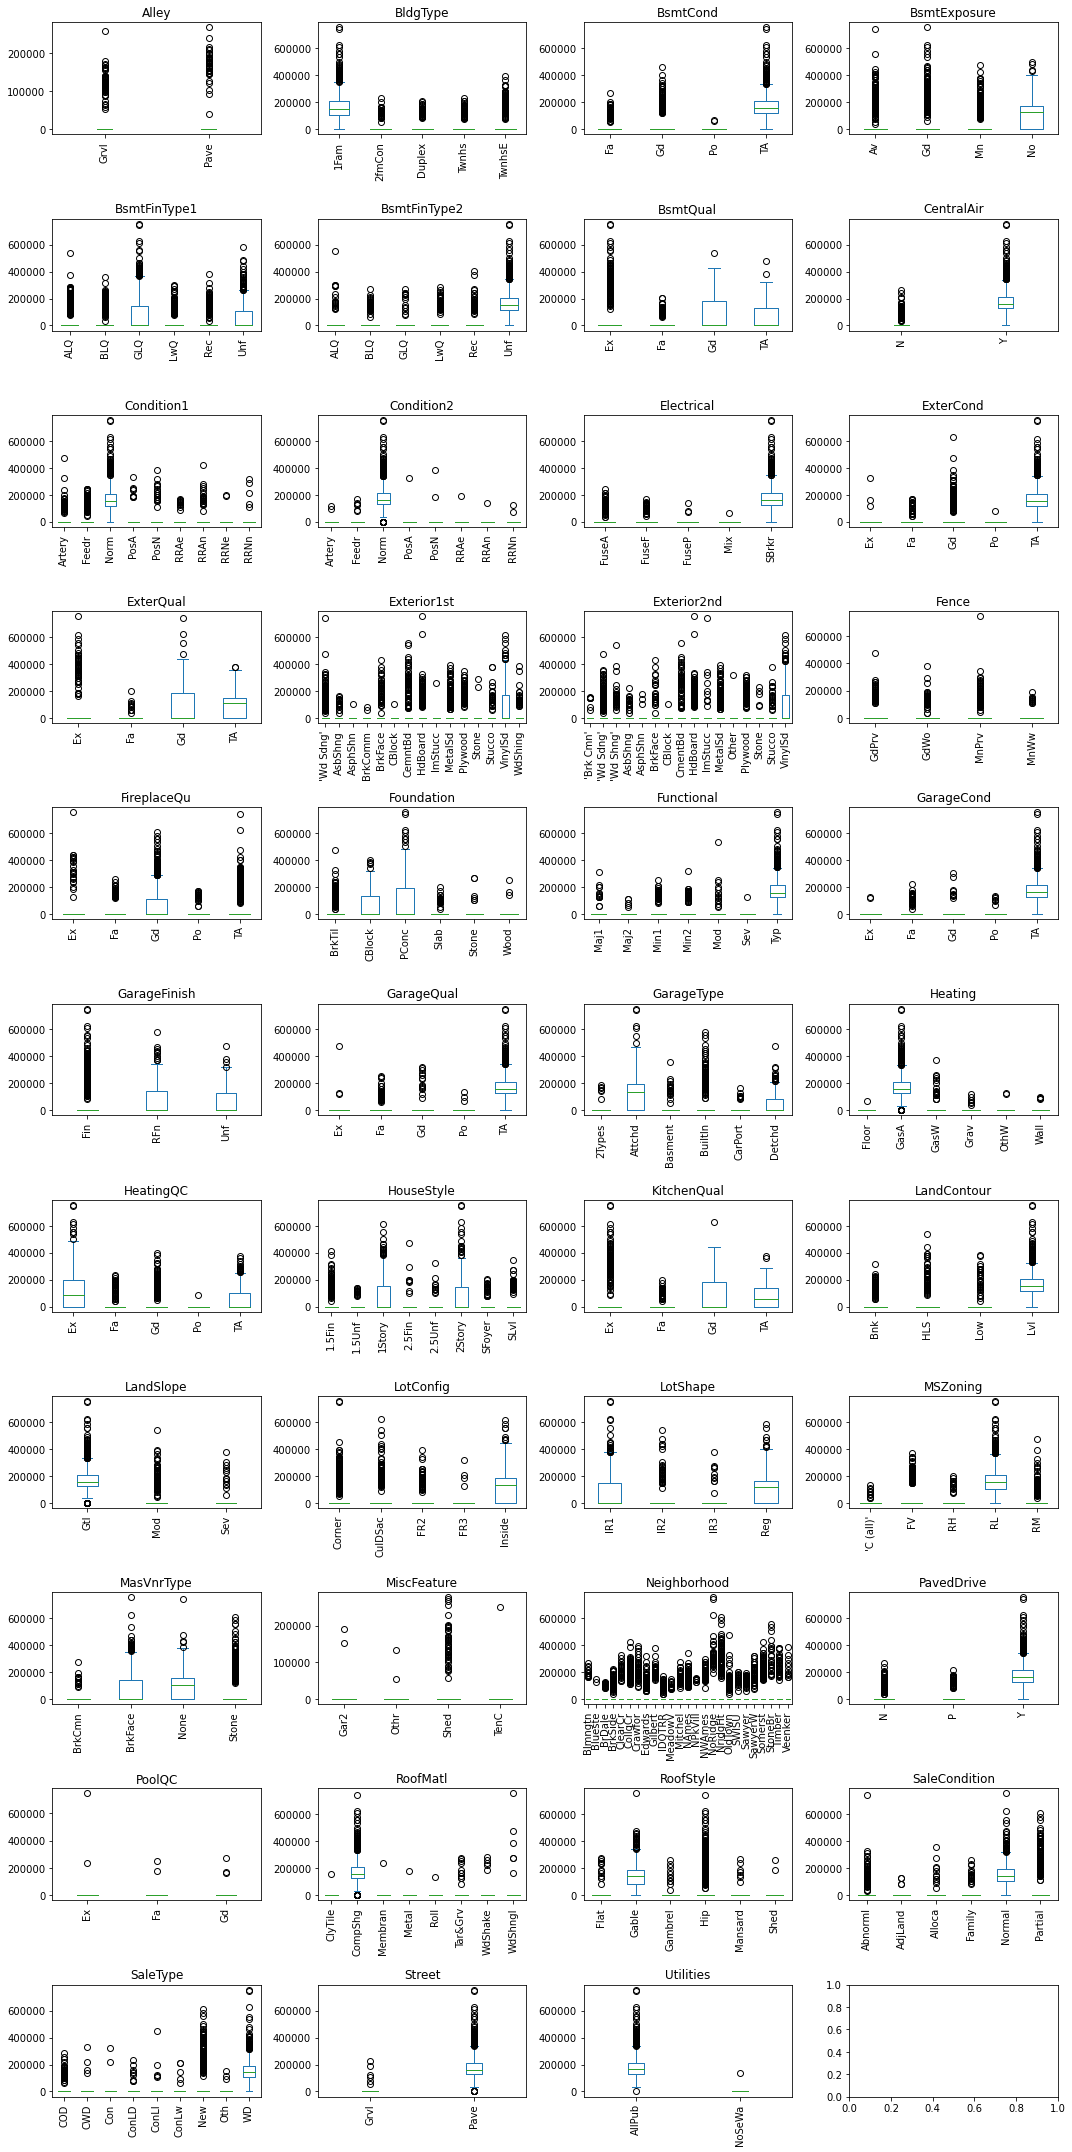

In [5]:
import matplotlib.pyplot as plt


height = 11
width = 4
fig, axes = plt.subplots(nrows=height, ncols=width)
categorical_df = house_price_df[house_price_df.columns.difference(numerical_df.columns)]
for i, column in enumerate(categorical_df.columns):
    row = i // width
    col= i % width
    # get_dummies: カテゴリごとに列を作成し、値がある箇所に1、ない箇所を0にする。
    sale_price_for_each_item = pd.get_dummies(categorical_df[column]).multiply(house_price_df["SalePrice"], axis=0)
    sale_price_for_each_item.plot.box(ax=axes[row, col], figsize=(15, 30), title=column, legend=False, rot=90)

plt.tight_layout()

**同じカテゴリ項目でもSalePriseの幅が大きいことがわかります**。また、70万ドルを超える全体からして高額な住宅があることも読み取れます。可視化の分析以外に、簡単な機械学習モデルを使って精度や重要な特徴量を分析するのも有効です。

### コミュニケーション演習

データサイエンティストとして、Analyzeの結果次の傾向を発見しました。必要性と十分性を確認するために、誰にどのような質問をすべきでしょうか。

* `PoolQC`など半分以上空白の値が5つ以上ある。
* `OverallQual`などは価格の予測に強く影響している。
* 同じカテゴリ項目でもSalePriseの幅が大きい。


| 英語名             | 日本語名                   | 役割                                                                 |
|--------------------|----------------------------|------------------------------|
| Product Manager    | プロダクトマネージャー     | ユーザー体験を向上させるために実装すべきソフトウェア機能を定義する。 |
| Business Analyst   | ビジネスアナリスト         | 解決すべきビジネス上の問題を定義する                                 |
| Data Analyst       | データアナリスト           | データの可視化と分析で問題を定量的に特定する。                       |
| Architect          | アーキテクト               | ソフトウェアアーキテクチャ全体を設計する。                           |
| DevOps Engineer    | DevOpsエンジニア           | ソフトウェアの開発・運用プロセスを自動化する。                       |
| Software Engineer  | ソフトウェアエンジニア     | ソフトウェアの開発を行う。                                           |
| Operator           | 業務担当者                 | ソフトウェアを利用し業務を行う。                                     |
| System Admin       | システム管理者             | サービスの挙動を監視する。                                           |
| IT Auditor         | IT監督者                   | システムや会社全体の権限管理や監査を行う。                           |
| Data architect     | データアーキテクト         | データを管理する基盤を設計、運用する。                               |
| Domain Expert      | 業務有識者                 | 深い業務知識を持ちデータの意味やあるべき状態について定義する。       |
| Data Scientist     | データサイエンティスト     | 機械学習モデルを開発する。                                           |

#### 質問例

* Domain Expert
   * 欠損が多い`PoolQC`などは本当に値が入っていないか、値が入っていない理由は何か。
   * `OverallQual`などは分析から販売価格に強く影響しているように見えるが感覚と合っているか。
   * カテゴリ項目は価格を決定する要素としては弱いように見えるがどのような項目なのか?
* Data architect/Software Engineer
   * 欠損が多い`PoolQC`などは本当に値が入っていないか、値が入っていない理由は何か。
   * 現在分析に使用しているデータのメタデータ(いつ頃誰が作成したのかなど)を教えてほしい。
* Data Analyst
   * 現在データの分析によく利用している項目は何か。
   
## Next Step

[Prepare](03_prepare.ipynb)

## References

1. [Pandas Cheet Sheet](https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf)
2. ゆずたそ and はせりょ. [データマネジメントが30分でわかる本](https://www.amazon.co.jp/%E3%83%87%E3%83%BC%E3%82%BF%E3%83%9E%E3%83%8D%E3%82%B8%E3%83%A1%E3%83%B3%E3%83%88%E3%81%8C30%E5%88%86%E3%81%A7%E3%82%8F%E3%81%8B%E3%82%8B%E6%9C%AC-%E3%82%86%E3%81%9A%E3%81%9F%E3%81%9D-ebook/dp/B085W4YSZJ). 2020.


関連するAWSのサービス

1. DataBrew
2. SageMaker Clarify
3. Athena
4. Redshift
5. QuickSight
